In [1]:
data_label = 'capsule'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
sys.argv = [sys.argv[0], '--mixing', '--sched', 'mvtec_single_out/'+data_label]# '--loss', 'r1'

import argparse
import random
import math

from tqdm import tqdm
from PIL import Image

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable, grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils

from dataset import MultiResolutionDataset2
from model import StyledGenerator, Discriminator, Encoder, ShortDiscriminator, StyledGenerator2

from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import imgaug as ia
import imgaug.augmenters as iaa

import numpy as np
import matplotlib.pyplot as plt
import cv2 
from scipy.spatial import distance

def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag


def accumulate(model1, model2, decay=0.999):
    par1 = dict(model1.named_parameters())
    par2 = dict(model2.named_parameters())

    for k in par1.keys():
        par1[k].data.mul_(decay).add_(1 - decay, par2[k].data)


def sample_data(dataset, batch_size, image_size=4):
    dataset.resolution = image_size
    loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=1, drop_last=True)

    return loader


def adjust_lr(optimizer, lr):
    for group in optimizer.param_groups:
        mult = group.get('mult', 1)
        group['lr'] = lr * mult
        
from PIL import Image
image = Image.open('data/test/capsule/squeeze/001.png')

resize_image = image.resize((512, 512))
AAA = None
BBB = None
    
    
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance


def sortpts_clockwise(A):
    sortedAc2 = A[np.argsort(A[:,1]),:]
    top2 = sortedAc2[0:2,:]
    bottom2 = sortedAc2[2:,:]
    sortedtop2c1 = top2[np.argsort(top2[:,0]),:]
    top_left = sortedtop2c1[0,:]
    sqdists = distance.cdist(top_left[None], bottom2, 'sqeuclidean')
    rest2 = bottom2[np.argsort(np.max(sqdists,0))[::-1],:]
    return np.concatenate((sortedtop2c1,rest2),axis =0)
        
    
class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.ChangeColorTemperature((1100, 10000)),
            iaa.KeepSizeByResize( iaa.Crop(percent=(0.0, 0.5), keep_size=False) ),
            iaa.Flipud(0.5),
            iaa.Fliplr(0.5),
        ])

        self.mask = np.zeros((512, 512, 1), dtype=np.int8)
    
    def distortion(self, img):
        A = img.shape[0] / 3.0
        w = 2.0 / img.shape[1]

        shift = lambda x: A * np.sin(2.0*np.pi*x * w)

        #for i in range(img.shape[0]):
        #ret = np.roll(np.array(img[:,:,:]), int(shift(i)))
        
        if (np.random.randint(2) == 0):
            for i in range(img.shape[0]):
                img[i,:,0] = torch.tensor( np.roll(img[i,:,0], int(shift(i))) )
                img[i,:,1] = torch.tensor( np.roll(img[i,:,1], int(shift(i))) )
                img[i,:,2] = torch.tensor( np.roll(img[i,:,2], int(shift(i))) )
        else:
            for i in range(img.shape[1]):
                img[:,i,0] = torch.tensor( np.roll(img[:,i,0], int(shift(i))) )
                img[:,i,1] = torch.tensor( np.roll(img[:,i,1], int(shift(i))) )
                img[:,i,2] = torch.tensor( np.roll(img[:,i,2], int(shift(i))) )
            
        return img

    def __call__(self, img):
        img = np.array(img)
        tile_size = img.shape[0]
        step = int(np.log2(tile_size / 4.0))
        self.mask[:] = 0
        #self.mask = self.masks[step][:, :, :]
        n = int(np.random.rand(1) * 7 + 3)
        xy = np.random.uniform(low=0.2, high=0.8, size=(2))
        #wh = (np.random.normal(0.2, 0.1, size=(2)))
        wh = np.random.uniform(low=0.2, high=0.8, size=(2))
        

        polys = np.random.rand(10*4).reshape(10, 4)
        wh = np.random.uniform(low=0.2, high=0.8, size=(2))
        n = 5
        tile_size = 512
        num = np.random.randint(10) + 1
        for i in range(11-num):
            cv2.line(self.mask,(int(polys[i, 0]*tile_size), int(polys[i, 1]*tile_size)),
                        (int(polys[i, 2]*tile_size), int(polys[i, 3]*tile_size)),(1),1)
        polys = np.random.rand(10*4).reshape(10, 4)
        wh = np.random.uniform(low=0.2, high=0.8, size=(2))
        for i in range(11-num):
            cv2.line(self.mask,(int(polys[i, 0]*tile_size), int(polys[i, 1]*tile_size)),
                        (int(polys[i, 2]*tile_size), int(polys[i, 3]*tile_size)),(1),2)
        polys = np.random.rand(10*4).reshape(10, 4)
        wh = np.random.uniform(low=0.2, high=0.8, size=(2))
        for i in range(11-num):
            cv2.line(self.mask,(int(polys[i, 0]*tile_size), int(polys[i, 1]*tile_size)),
                        (int(polys[i, 2]*tile_size), int(polys[i, 3]*tile_size)),(1),3)
               
        ret_mask = cv2.resize(self.mask.astype(np.uint8), dsize=(img.shape[0], img.shape[1]), interpolation=cv2.INTER_CUBIC)
        ret_mask = ret_mask[:, :, None]
        img_anom = img
        img_anom = (self.aug.augment_image( np.array(img_anom).astype(np.uint8) ).copy()).astype(np.float32)
        ret = (img - ret_mask*img) + (ret_mask * img_anom)#img_anom#(img - self.mask*img) + (self.mask * img_anom)
        
        return np.concatenate((ret, ret_mask), axis=2)

ia_transform = ImgAugTransform()

code_size = 512
base_batch_size = 2 #16
n_critic = 1

parser = argparse.ArgumentParser(description='Progressive Growing of GANs')

parser.add_argument('path', type=str, help='path of specified dataset')
parser.add_argument(
    '--phase',
    type=int,
    default=20_000, #600_000
    help='number of samples used for each training phases',
)
parser.add_argument('--lr', default=0.001, type=float, help='learning rate')
parser.add_argument('--sched', action='store_true', help='use lr scheduling')
parser.add_argument('--init_size', default=512, type=int, help='initial image size') #2^9
parser.add_argument('--max_size', default=512, type=int, help='max image size')
parser.add_argument(
    '--ckpt', default='checkpt/'+data_label+'/train_step-7.model', type=str, help='load from previous checkpoints'
)
parser.add_argument(
    '--no_from_rgb_activate',
    action='store_true',
    help='use activate in from_rgb (original implementation)',
)
parser.add_argument(
    '--mixing', action='store_true', help='use mixing regularization'
)
parser.add_argument(
    '--loss',
    type=str,
    default='wgan-gp',
    choices=['wgan-gp', 'r1'],
    help='class of gan loss',
)

args = parser.parse_args()


g2_running = StyledGenerator2(code_size).cuda()
g_running = StyledGenerator(code_size).cuda()
e_running = Encoder(from_rgb_activate=not args.no_from_rgb_activate).cuda()

g2_optimizer = optim.Adam(
    g2_running.generator.parameters(), lr=args.lr, betas=(0.0, 0.99)
)
g2_optimizer.add_param_group(
    {
        'params': g2_running.style.parameters(),
        'lr': args.lr * 0.01,
        'mult': 0.01,
    }
)

g_optimizer = optim.Adam(
    g_running.generator.parameters(), lr=args.lr, betas=(0.0, 0.99)
)
g_optimizer.add_param_group(
    {
        'params': g_running.style.parameters(),
        'lr': args.lr * 0.01,
        'mult': 0.01,
    }
)

e_optimizer = optim.Adam(e_running.parameters(), lr=args.lr, betas=(0.0, 0.99))

assert args.ckpt is not None
ckpt = torch.load(args.ckpt)

#generator.module.load_state_dict(ckpt['generator'])
g_running.load_state_dict(ckpt['g_running'])
#g_optimizer.load_state_dict(ckpt['g_optimizer'])


transform = transforms.Compose(
    [
        #transforms.RandomHorizontalFlip(),
        ia_transform,
        #transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
    ]
)

transform2 = transforms.Compose(
    [
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), inplace=True),
    ]
)

dataset = MultiResolutionDataset2(args.path, transform, transform2)

if args.sched:
    args.lr = {128: 0.0015, 256: 0.002, 512: 0.003, 1024: 0.003}
    args.batch = {4: 128, 8: 64, 16: 32, 32: 16, 64: 8, 128: 8, 256: 2, 512: 2} #8

else:
    args.lr = {}
    args.batch = {}

args.gen_sample = {512: (8, 4), 1024: (4, 2)}

args.batch_default = base_batch_size * 2


def toImage(tensor):
    A = tensor.clone()
    A -= A.min()
    A /= A.max()
    
    return A


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:

ckpt = torch.load('checkpt/'+data_label+'/bestg2.model')
g2_running.load_state_dict(ckpt)
ckpt = torch.load('checkpt/'+data_label+'/beste.model')
e_running.load_state_dict(ckpt)

resolution = 512
encoder = e_running
generator = g_running
generator2 = g2_running
step = 7
alpha = 1

gen_in1, gen_in2 = torch.randn(2, 1, code_size, device='cuda').chunk(
                    2, 0
                )
gen_in1 = gen_in1.squeeze(0)

In [4]:
import cv2 as cv
import os
from PIL import Image
import matplotlib.pyplot as plt

def get_holes(image, thresh):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    im_bw = cv.threshold(gray, thresh, 255, cv.THRESH_BINARY)[1]
    im_bw_inv = cv.bitwise_not(im_bw)

    contour, _ = cv.findContours(im_bw_inv, cv.RETR_CCOMP, cv.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv.drawContours(im_bw_inv, [cnt], 0, 255, -1)

    nt = cv.bitwise_not(im_bw)
    im_bw_inv = cv.bitwise_or(im_bw_inv, nt)
    return im_bw_inv


def remove_background(image, thresh, scale_factor=.25, kernel_range=range(1, 15), border=None):
    border = border or kernel_range[-1]

    holes = get_holes(image, thresh)
    small = cv.resize(holes, None, fx=scale_factor, fy=scale_factor)
    bordered = cv.copyMakeBorder(small, border, border, border, border, cv.BORDER_CONSTANT)

    for i in kernel_range:
        kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (2*i+1, 2*i+1))
        bordered = cv.morphologyEx(bordered, cv.MORPH_CLOSE, kernel)

    unbordered = bordered[border: -border, border: -border]
    mask = cv.resize(unbordered, (image.shape[1], image.shape[0]))
    fg = cv.bitwise_and(image, image, mask=mask)
    return fg, mask

num_file = 0
r_list = []
test_root = './data/test/'+data_label+'/'
gt_root = './data/test/'+data_label+'_gt/'

# traverse root directory, and list directories as dirs and files as files
for root, dirs, files in os.walk(test_root):
    path = root.split(os.sep)
    #print(path)
    print((len(path) - 1) * '---', os.path.basename(root))
    if path[-1] == 'good' or path[-1] == '.ipynb_checkpoints':
        continue
    r_list_sub = []
    for file in tqdm(sorted(files[:])):
        if '.png' == file[-4:] and path[-1] != '':
            # Open the image form working directory
            anomaly = Image.open(test_root + str(path[-1]) + '/' + file)
            gt = Image.open(gt_root + str(path[-1]) + '/' + file[:-4] + '_mask.png')
            gt = gt.resize((512, 512))
            anomaly = anomaly.resize((512, 512))
            #resize_image = image
            #anomaly_image = torch.from_numpy(np.array(resize_image)[None, :, :, :]).permute(0, 3, 1, 2) / 255.0
            #anomaly_image = anomaly_image.cuda()
            #plt.imshow( gt )
            
            #plt.imshow( toImage(resize_image.data.detach().cpu()[0]).permute(1, 2, 0)  )
            #anomaly = cv2.cvtColor(np.array(anomaly),cv2.COLOR_GRAY2RGB)
            
            gen_in1, gen_in2 = torch.randn(2, 1, code_size, device='cuda').chunk(
                    2, 0
                )
            gen_in1 = gen_in1.squeeze(0)

            ground_truth = 1 - (torch.from_numpy(np.array(gt)[:, :]).permute(0, 1) / 255.0)
            anomaly_image = torch.from_numpy(np.array(anomaly)[None, :, :, :]).permute(0, 3, 1, 2) / 255.0
            anomaly_image = anomaly_image.cuda()
            
            anomaly_image = anomaly_image
            anomaly_image = anomaly_image * 2
            anomaly_image = anomaly_image - 1.0

            #out = encoder(anomaly_image, step=step, alpha=alpha)
            (out, skiplist) = encoder(anomaly_image, step=step, alpha=alpha)
            skiplist = skiplist[1:]
            skiplist.insert(0, None)

            out_orin, fake_image     = generator([gen_in1], styles=[out[:, :512]], step=step, alpha=alpha)
            out_orin, (fake_image2, mask)     = generator2(skiplist, fake_image, anomaly_image, [gen_in1], styles=[out[:, 512:]], step=step, alpha=alpha)
            
            
            gt_image = torch.from_numpy(np.array(gt)[None, :, :]) / 255.0
            #gt_image = gt_image.cuda()
            gt_image_im =torch.from_numpy(np.array(( toImage(torch.sum( gt_image.data[:, :, :], axis = 0) ) ) ))
            
            
            fake_image_norm = (1 - mask) * fake_image + mask * anomaly_image


            anomaly_image_norm = anomaly_image
            anomaly_image_norm = (anomaly_image_norm - torch.min(anomaly_image_norm))
            anomaly_image_norm = anomaly_image_norm / (torch.max(anomaly_image_norm) + 1e-6)

            
            img_diff = mask
            #img_diff = fake_image_norm - anomaly_image_norm#mask#
            img_diff = torch.sum( torch.abs(img_diff), axis = 0)
            img_diff = torch.from_numpy(np.array(( toImage(torch.sum( img_diff.data.cpu()[:, :, :], axis = 0) ) ) )).permute(0, 1)
            #plt.imshow( img_diff  )
            
            #img_diff = mask
            fg = torch.from_numpy(np.array(( toImage( anomaly_image.data.cpu()[0, :, :, :] ) ) )).permute(1, 2, 0)
            img = np.array(fg*255).astype(np.uint8)
            nb_img, mask_fg = remove_background(img, 120)
            #mask_fg[:] = 1
            
            #diff = diff * ground_truth.expand_as(diff)
            kernel = np.ones((9,9),np.uint8)
            img_diff = cv2.dilate(np.array(img_diff),kernel,iterations = 1)
            ret = ((torch.tensor(img_diff) > 0.2) & (mask_fg > 0) )
            gt = (gt_image_im > 0)
            
            score = float(torch.sum ( ret & gt ).item()) / torch.sum ( ret | gt ).item()
            
            #plt.imshow( diff )
            r_list_sub.append(score)
            
    r_list.append(r_list_sub)
            #r_list.append((torch.sum(diff) / torch.sum(ground_truth) ).item())
            #num_file += 1
            #plt.imsave('./test/'+'result/'+str(num_file)+'.png', diff)
            


0it [00:00, ?it/s]
  4%|▍         | 1/23 [00:00<00:03,  5.52it/s]

------------ 
------------ crack


  5%|▌         | 1/20 [00:00<00:03,  5.56it/s]

--------------- .ipynb_checkpoints
------------ squeeze


  5%|▍         | 1/22 [00:00<00:03,  5.68it/s]

------------ good
------------ .ipynb_checkpoints
------------ faulty_imprint


  5%|▍         | 1/21 [00:00<00:03,  5.57it/s]

------------ poke


  4%|▍         | 1/23 [00:00<00:03,  5.67it/s]

------------ scratch


100%|██████████| 23/23 [00:04<00:00,  5.61it/s]


In [5]:
length = 0
sum_score = 0
for s_list in r_list:
    length += len(s_list)
    sum_score += sum(s_list)
print("Score: " + str(sum_score / length))


str_l = ["crack", "squeeze", "faulty_imprint", "poke", "scratch"]

k = 0
for i in range(len(r_list)):
    if len(r_list[i]) > 0:
        print(str_l[k])
        print(sum(r_list[i]) / len(r_list[i]))
        k += 1

Score: 0.3517138839117561
crack
0.42022369233421025
squeeze
0.17951857274172212
faulty_imprint
0.38608303128525195
poke
0.44606740066881223
scratch
0.3139154289365015


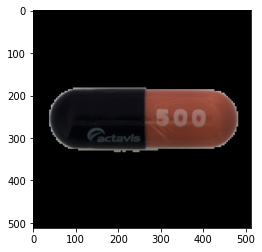

In [6]:
nb_img, mask_fg = remove_background(img, 120)
plt.imshow( nb_img )

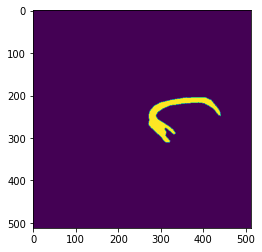

In [7]:
plt.imshow(gt)

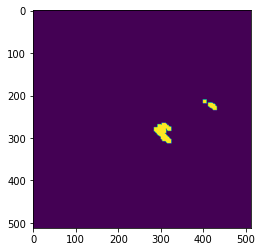

In [8]:
plt.imshow(ret)

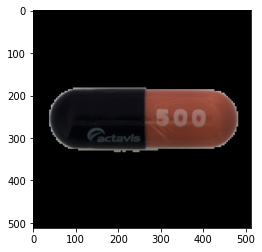

In [9]:
nb_img, mask_fg = remove_background(img, 120)
plt.imshow(nb_img )